### <font color="2E4053"><b> Regression on Mobile Phone Dataset (Divar) </b></font>
Mahsa Eskandari Ghadi <br>
Student No. 810196597 <br>

In this project we tried Linear Regression, Decision Tree Regression and Random Forest Regression, on a cellphone dataset in order to predict prices. The main steps include: loading data, cleaning data, feature selection, check model performances and tuning the hyperparameters. (repeat last the last two until we get acceptable scores and error values.)

In [133]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.feature_selection import mutual_info_classif #For calculating information gain

from sklearn.preprocessing import LabelEncoder #For numeralizing the categorical features

from sklearn.preprocessing import StandardScaler #For scaling data

from sklearn.model_selection import train_test_split #For spliting data into 2 sets of train and test

from collections import Counter

#Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#Performance Measures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Farsi language processing lib
#!pip install hazm
from hazm import *

The function below is used through out the code to plot and see the R2 scores vs the hyperparameter value in order to determine the best performance with the least overfitting.

In [134]:
def plot_param_vs_r2 (param, test_r2, train_r2, param_name) :

    acc_fig = plt.figure()
    ax = acc_fig.add_axes([0,0,1,1])
    ax.plot(param, train_r2, label="train", linewidth=1, color='#2E4053')
    ax.plot(param, test_r2, label='test', linewidth=1, color='#C0392B')
    ax.legend()
    ax.set_title('R2 vs. {}'.format(param_name))
    ax.set_xlabel(param_name)
    ax.set_ylabel('r2')

### <font color="2E4053  "><b> Part 0: Quick Glance at the Dataset </b></font>
The data of our project is a record of Divar users who are looking to sell cellphones with helpful details of the brand of the cellphone, the city the seller resides in, the name and model of the phone, a short description, the number of images they included in the ad, the day of the week and hour they posted the ad and lastly the price that they put on their phones. <font color="73C6B6"> Our goal is to construct a model that will predict the price for mobile phones with a reasonable R2score and mean absolute error.

In [135]:
df = pd.read_csv("mobile_phone_dataset.csv")
df.head()

,Unnamed: 0,brand,city,title,desc,image_count,created_at,price
0,0,Nokia::نوکیا,Qom,نوکیا6303,سلام.یه گوشیه6303سالم که فقط دوتا خط کوچیک رو ...,2,Wednesday 07AM,60000
1,1,Apple::اپل,Tehran,ایفون ٥اس٣٢گیگ,درحد نو سالم اصلى بدون ضربه مهلت تست میدم,0,Wednesday 11AM,1150000
2,2,Samsung::سامسونگ,Mashhad,سامسونگ j5,گوشى بسیار بسیار تمیز و فقط سه هفته کارکرده و ...,2,Wednesday 02PM,590000
3,3,Apple::اپل,Karaj,گرى 5s ایفون 32گیگ,گلس پشت و رو .کارت اپل ای دی. لوازم جانبی اصلی...,3,Wednesday 04PM,1100000
4,4,Samsung::سامسونگ,Tehran,galaxy S5 Gold در حد آک,کاملا تمیز و بدون حتی 1 خط و خش\nبه همراه گلاس...,2,Friday 01PM,900000


### <font color="2E4053"><b> Part 1: Preprocessing and Cleaning Data </b></font>

For cleaning the data I took these steps:
- Change the created at format (seperate day from time)
- Change the brand format (delete the Farsi part)
- Define features and target (X, y)
- Drop some features (Unnamed: 0, desc)
- Label Encode and OneHot Encode the categorical features
- Plot Information Gain
- Feature select
- Extract features from the title

After each step the head of the dataframe is shown to check the change has really been made.

In [136]:
df[['day','time']] = df['created_at'].str.split(' ', 1, expand=True)
df = df.drop(columns=['created_at'])
df.head()

,Unnamed: 0,brand,city,title,desc,image_count,price,day,time
0,0,Nokia::نوکیا,Qom,نوکیا6303,سلام.یه گوشیه6303سالم که فقط دوتا خط کوچیک رو ...,2,60000,Wednesday,07AM
1,1,Apple::اپل,Tehran,ایفون ٥اس٣٢گیگ,درحد نو سالم اصلى بدون ضربه مهلت تست میدم,0,1150000,Wednesday,11AM
2,2,Samsung::سامسونگ,Mashhad,سامسونگ j5,گوشى بسیار بسیار تمیز و فقط سه هفته کارکرده و ...,2,590000,Wednesday,02PM
3,3,Apple::اپل,Karaj,گرى 5s ایفون 32گیگ,گلس پشت و رو .کارت اپل ای دی. لوازم جانبی اصلی...,3,1100000,Wednesday,04PM
4,4,Samsung::سامسونگ,Tehran,galaxy S5 Gold در حد آک,کاملا تمیز و بدون حتی 1 خط و خش\nبه همراه گلاس...,2,900000,Friday,01PM


In [137]:
df['brand'] = df['brand'].str.split('::', 1, expand=True)
df.head()

,Unnamed: 0,brand,city,title,desc,image_count,price,day,time
0,0,Nokia,Qom,نوکیا6303,سلام.یه گوشیه6303سالم که فقط دوتا خط کوچیک رو ...,2,60000,Wednesday,07AM
1,1,Apple,Tehran,ایفون ٥اس٣٢گیگ,درحد نو سالم اصلى بدون ضربه مهلت تست میدم,0,1150000,Wednesday,11AM
2,2,Samsung,Mashhad,سامسونگ j5,گوشى بسیار بسیار تمیز و فقط سه هفته کارکرده و ...,2,590000,Wednesday,02PM
3,3,Apple,Karaj,گرى 5s ایفون 32گیگ,گلس پشت و رو .کارت اپل ای دی. لوازم جانبی اصلی...,3,1100000,Wednesday,04PM
4,4,Samsung,Tehran,galaxy S5 Gold در حد آک,کاملا تمیز و بدون حتی 1 خط و خش\nبه همراه گلاس...,2,900000,Friday,01PM


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59189 entries, 0 to 59188
Data columns (total 9 columns):
Unnamed: 0     59189 non-null int64
brand          59189 non-null object
city           59189 non-null object
title          59189 non-null object
desc           59189 non-null object
image_count    59189 non-null int64
price          59189 non-null int64
day            59189 non-null object
time           59189 non-null object
dtypes: int64(3), object(6)
memory usage: 4.1+ MB


In [139]:
y_df = df[df['price'] == -1]

In [170]:
X = df.drop(columns=['price']) 
indices = df[df['price'] == -1 ].index

X_train = X.drop(indices)
X_train = X_train.reset_index(drop=True)
y_train = df.drop(indices)['price']

X_test = X.iloc[indices]
X_test = X_test.reset_index(drop=True)

y_test = y_df['price']

In [171]:
X_test

,Unnamed: 0,brand,city,title,desc,image_count,day,time
0,23,Samsung,Karaj,A3 2015,گوشی در حده نو کلا 2 هفتس خریدمش.با تشکر از سا...,1,Tuesday,12PM
1,28,Apple,Qom,اپل 5s ٣٢ گیگ بسیار تمیز در حد,گوشی بسیار تمیز در حد قیمت مقطوع میباشد لطفا ت...,2,Saturday,04AM
2,32,Apple,Shiraz,اقساط٢٤ماهه بدون پیش پرداخت,اقساط ٢٤ماهه بدون پیش پرداخت,0,Sunday,03PM
3,37,Sony,Qom,سونی مدل acro s گوشی هواوی y300,"گوشی سونی مدل acro s دوربین 12 فیلمبرداری HD ,...",2,Thursday,06AM
4,46,HTC,Tehran,ّگوشی موبایل htc desire610 جهت معاوضه,معاوضه با ایفون 4\nگوشیم سالم سالم 4g\nبدون هی...,0,Monday,08PM
5,54,Samsung,Isfahan,Apple 6s,گوشی اپل 6s نو 128 گیگ. پلمپ کارتن هنوز باز نش...,1,Saturday,04PM
6,60,HTC,Tehran,HTC one 801e,64 گیگ حافظه اندروید 5 هیچ خط و خشی روش نداره ...,2,Tuesday,08AM
7,62,Samsung,Ahvaz,s6 edge,فقط قابل معاوضه با گوشی .....,0,Wednesday,12PM
8,64,Samsung,Ahvaz,گوشی سامسونگ 7262,کاملا سالم . بدون خطو خش . دوربین عقب 5 . دو س...,1,Wednesday,06PM
9,80,HTC,Tehran,htc one e9 plos حتما بخون,در حد نو هست گوشی تاچ یه مقدار مشکل داره که با...,0,Thursday,12PM


In [141]:
y_test.head()

23   -1
28   -1
32   -1
36   -1
44   -1
Name: price, dtype: int64

In [142]:
y_test = y_test.reset_index(drop=True)
y_test.head()

0   -1
1   -1
2   -1
3   -1
4   -1
Name: price, dtype: int64

In [143]:
X_train = X_train.drop(columns=['Unnamed: 0', 'desc'])
X_train.head()

,brand,city,title,image_count,day,time
0,Nokia,Qom,نوکیا6303,2,Wednesday,07AM
1,Apple,Tehran,ایفون ٥اس٣٢گیگ,0,Wednesday,11AM
2,Samsung,Mashhad,سامسونگ j5,2,Wednesday,02PM
3,Apple,Karaj,گرى 5s ایفون 32گیگ,3,Wednesday,04PM
4,Samsung,Tehran,galaxy S5 Gold در حد آک,2,Friday,01PM


In [144]:
X_encoded = pd.get_dummies(X_train, columns=['brand', 'city'], drop_first=True)
X_encoded.head()

,title,image_count,day,time,brand_HTC,brand_Huawei,brand_LG,brand_Lenovo,brand_Nokia,brand_Samsung,brand_Sony,brand_ZTE,city_Isfahan,city_Karaj,city_Kermanshah,city_Mashhad,city_Qom,city_Shiraz,city_Tabriz,city_Tehran
0,نوکیا6303,2,Wednesday,07AM,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,ایفون ٥اس٣٢گیگ,0,Wednesday,11AM,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,سامسونگ j5,2,Wednesday,02PM,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,گرى 5s ایفون 32گیگ,3,Wednesday,04PM,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,galaxy S5 Gold در حد آک,2,Friday,01PM,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [145]:
le = LabelEncoder()
X_encoded['day'] = le.fit_transform(X_encoded['day'])
times = X_encoded['time']
hours = []
for i in range(len(times)):
    time_str = str(times[i])
    if (time_str.find('AM') != -1): 
        time_str = time_str.replace('AM', '')
        time = int(time_str)
    else: 
        time_str = time_str.replace('PM', '')
        time = int(time_str) + 12
    hours.append(time)
X_encoded['time'] = hours
X_encoded.head()

,title,image_count,day,time,brand_HTC,brand_Huawei,brand_LG,brand_Lenovo,brand_Nokia,brand_Samsung,brand_Sony,brand_ZTE,city_Isfahan,city_Karaj,city_Kermanshah,city_Mashhad,city_Qom,city_Shiraz,city_Tabriz,city_Tehran
0,نوکیا6303,2,6,7,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,ایفون ٥اس٣٢گیگ,0,6,11,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,سامسونگ j5,2,6,14,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,گرى 5s ایفون 32گیگ,3,6,16,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,galaxy S5 Gold در حد آک,2,0,13,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


### <font color="2E4053"><b> Part 2: Feature Selection</b></font>

In [146]:
X_mic = X_encoded.drop(columns=['title'])

Text(0, 0.5, 'Gain')

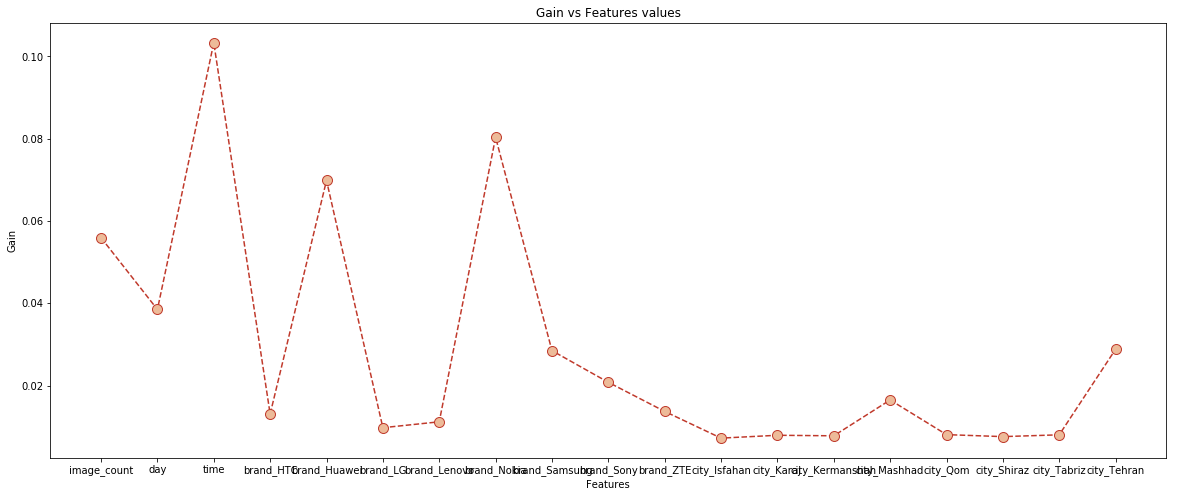

In [147]:
mic = mutual_info_classif(X_mic, y_train, discrete_features=True)
fig = plt.figure(figsize=(20,8))
plt.plot(X_mic.columns, mic, color='#C0392B', linestyle='dashed', marker='o', markerfacecolor='#EDBB99', markersize=10)
plt.title('Gain vs Features values')
plt.xlabel('Features')
plt.ylabel('Gain')

As it can be seen the time column has the most gain which doesn't really make sense because obviously the time of the day a person posts the ad should't really be affecting the price of the product. This can lead the model to make false predictions. It is only logical to drop these columns.

In [148]:
X_encoded = X_encoded.drop(columns=['time', 'day'])
X_encoded.head()

,title,image_count,brand_HTC,brand_Huawei,brand_LG,brand_Lenovo,brand_Nokia,brand_Samsung,brand_Sony,brand_ZTE,city_Isfahan,city_Karaj,city_Kermanshah,city_Mashhad,city_Qom,city_Shiraz,city_Tabriz,city_Tehran
0,نوکیا6303,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,ایفون ٥اس٣٢گیگ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,سامسونگ j5,2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,گرى 5s ایفون 32گیگ,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,galaxy S5 Gold در حد آک,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


Text(0, 0.5, 'Gain')

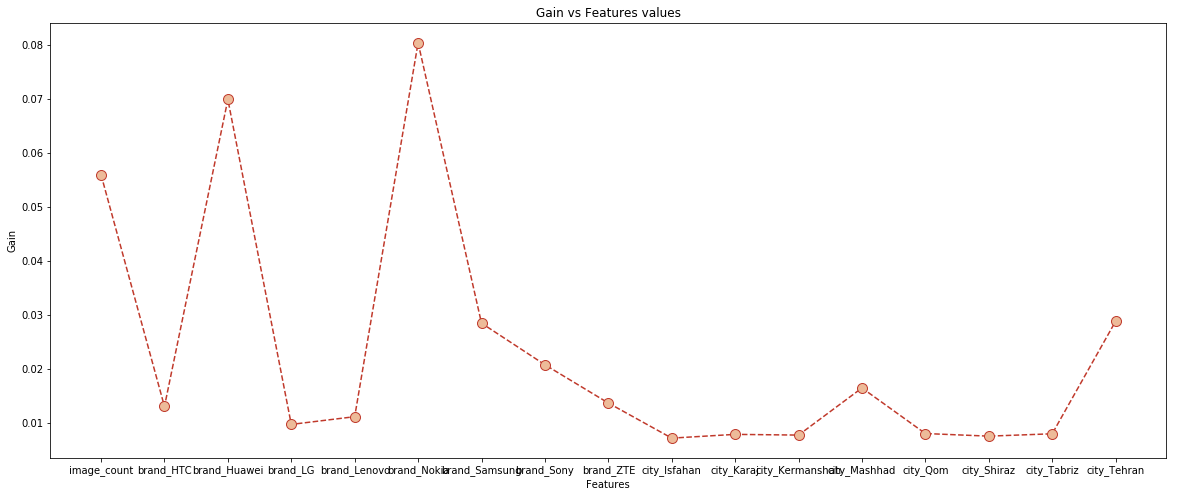

In [149]:
X_mic = X_encoded.drop(columns=['title'])
mic = mutual_info_classif(X_mic, y_train, discrete_features=True)
fig = plt.figure(figsize=(20,8))
plt.plot(X_mic.columns, mic, color='#C0392B', linestyle='dashed', marker='o', markerfacecolor='#EDBB99', markersize=10)
plt.title('Gain vs Features values')
plt.xlabel('Features')
plt.ylabel('Gain')

To extract features from the title these steps were taken:
- Normalize each title (remove un necessary spaces and such)
- Tokenize each title
- Get the count of each unique word
- Feature Select (remove some of the words)

In [150]:
normalizer = Normalizer()
titles = X_encoded['title']
titles_normalized = []

In [151]:
for title in titles:
    titles_normalized.append(normalizer.normalize(title))

In [152]:
X_encoded['title'] = titles_normalized
X_encoded.head()

,title,image_count,brand_HTC,brand_Huawei,brand_LG,brand_Lenovo,brand_Nokia,brand_Samsung,brand_Sony,brand_ZTE,city_Isfahan,city_Karaj,city_Kermanshah,city_Mashhad,city_Qom,city_Shiraz,city_Tabriz,city_Tehran
0,نوکیا۶۳۰۳,2,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,ایفون ٥اس٣٢گیگ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,سامسونگ j۵,2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,گرى ۵s ایفون ۳۲گیگ,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,galaxy S۵ Gold در حد آک,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


In [153]:
titles = X_encoded['title']
titles_tokenized = []

In [154]:
for title in titles:
    titles_tokenized.append(word_tokenize(title))

In [155]:
for i in range(len(titles_tokenized)):
    titles_tokenized[i] = [x.lower() for x in titles_tokenized[i]]

In [156]:
titles_flattened = [j for sub in titles_tokenized for j in sub] 

In [157]:
titles_df = pd.DataFrame(titles_flattened)
word_series = titles_df[0].value_counts()
word_dict = word_series.to_dict()

word_dict

{'گوشی': 16362,
 'سامسونگ': 7977,
 'موبایل': 4551,
 'g': 3279,
 'iphone': 2991,
 '۱۶': 2884,
 'هواوی': 2741,
 'گیگ': 2603,
 'ایفون': 2587,
 '۶۴': 2569,
 '۵s': 2470,
 'جی': 2416,
 'نوکیا': 2400,
 'سونی': 2243,
 '۳۲': 2160,
 '۶': 2121,
 'اپل': 2113,
 'گلکسی': 2081,
 'آیفون': 2051,
 'اس': 1863,
 'تمیز': 1828,
 'حد': 1763,
 '.': 1746,
 'در': 1699,
 'فروش': 1640,
 'htc': 1582,
 '۶s': 1537,
 '۵': 1535,
 'نو': 1330,
 'گلد': 1214,
 'gb': 1208,
 'سالم': 1144,
 'ال': 1133,
 'gold': 1115,
 '۲۰۱۶': 1115,
 'مدل': 1103,
 'نوت': 1094,
 'y': 1050,
 'و': 1040,
 'معاوضه': 1027,
 'samsung': 1021,
 'gig': 1003,
 'galaxy': 984,
 '۴': 950,
 '(': 920,
 'سی': 912,
 ')': 878,
 'هوآوی': 846,
 '۴g': 824,
 'دوسیم': 801,
 'مشکی': 792,
 'با': 764,
 'lg': 751,
 'سیم': 737,
 '۳': 733,
 's۶': 731,
 'سفید': 726,
 'تی': 706,
 '۲': 685,
 'اک': 683,
 'اچ': 680,
 'sony': 674,
 '۴s': 664,
 'apple': 656,
 'huawei': 655,
 'آک': 640,
 '٦': 627,
 'دو': 617,
 'فورجی': 591,
 's': 581,
 's۵': 574,
 '۶۱۰': 572,
 'پلاس': 572,
 'gray

<font color="C0392B"> <b> WORDS TO REMOVE AS FEATURES </b> </font> <br>

The most word used is <font color="2E4053"> <b> "گوشی" </b> </font> meaning "phone" which there is no gain in keeping it since we know our whole dataset is phones and phones only. Next we should remove the <font color="2E4053"> <b>brands </b> </font>since again we already have the brands in a whole column and keeping them is just repeating features. Also <font color="2E4053"> <b> stop-words </b> </font> like <font color="2E4053"><b>  "و" ,"با" ,"در" and "یا" </b> </font> were removed.


In [158]:
words_to_delete = ["گوشی", "موبایل", "سامسونگ", "هواوی", "گیگ" ,"آیفون","samsung", "asus", "شیائومی", "ایسوس","ایفون", "iphone", "نوکیا", "سونی", "اپل", "htc", "هوآوی", "الجی", "و", "با", "در"]
for word in words_to_delete:
    del word_dict[word]

In [159]:
word_dict

{'g': 3279,
 '۱۶': 2884,
 '۶۴': 2569,
 '۵s': 2470,
 'جی': 2416,
 '۳۲': 2160,
 '۶': 2121,
 'گلکسی': 2081,
 'اس': 1863,
 'تمیز': 1828,
 'حد': 1763,
 '.': 1746,
 'فروش': 1640,
 '۶s': 1537,
 '۵': 1535,
 'نو': 1330,
 'گلد': 1214,
 'gb': 1208,
 'سالم': 1144,
 'ال': 1133,
 'gold': 1115,
 '۲۰۱۶': 1115,
 'مدل': 1103,
 'نوت': 1094,
 'y': 1050,
 'معاوضه': 1027,
 'gig': 1003,
 'galaxy': 984,
 '۴': 950,
 '(': 920,
 'سی': 912,
 ')': 878,
 '۴g': 824,
 'دوسیم': 801,
 'مشکی': 792,
 'lg': 751,
 'سیم': 737,
 '۳': 733,
 's۶': 731,
 'سفید': 726,
 'تی': 706,
 '۲': 685,
 'اک': 683,
 'اچ': 680,
 'sony': 674,
 '۴s': 664,
 'apple': 656,
 'huawei': 655,
 'آک': 640,
 '٦': 627,
 'دو': 617,
 'فورجی': 591,
 's': 581,
 's۵': 574,
 '۶۱۰': 572,
 'پلاس': 572,
 'gray': 565,
 'j۷': 564,
 '١٦': 564,
 'گرند': 562,
 'edge': 552,
 's۴': 550,
 's۳': 544,
 'درحد': 503,
 'plus': 500,
 'a۵': 493,
 'j۵': 492,
 'اصلی': 485,
 '٦٤': 484,
 '،': 468,
 's۷': 464,
 'n': 461,
 'one': 453,
 '۱۰': 451,
 'lla': 445,
 'note': 442,
 '۷': 440,


In [160]:
len(word_dict)

11350

 <font color="2E4053"> <b> The less likely a word is used the more information it contains thus the more special it is. </b> </font> but also the looking at the least used words we realize that they are usually spelling errors. So we'll take the words that have been used at least 10 times and throw the rest away, leaving us 1103 words out of 11350. Note that, we also don't want too many features because that will lead the model to overfit. 1103 to 53301 of the whole data is reasonable in this situation.

In [161]:
word_dict = dict((key, value) for key, value in word_dict.items() if value >= 10)

In [162]:
len(word_dict)

1103

Now we want to give values to those features by checking a box of yes or no. If the tile contains that word we check yes(1) else no(0). Then we concat these new columns to the dataframe for X.

In [163]:
new_columns = np.zeros((len(word_dict), len(titles_tokenized)))

In [164]:
for i in range(len(titles_tokenized)):
    for j, word in enumerate(word_dict):
        if word in titles_tokenized[i]:
            new_columns[j][i] = 1

In [165]:
cols = list(range(len(word_dict)))
cols_str = [str(x) for x in cols]
rows = list(range(len(titles_tokenized)))
rows_str = [str(x) for x in rows]
new_cols = pd.DataFrame(new_columns)
new_cols = new_cols.T

In [166]:
X_train = pd.concat([X_encoded, new_cols], axis=1)

In [167]:
X_train = X_train.drop(columns=['title'])
X_train.head()

,image_count,brand_HTC,brand_Huawei,brand_LG,brand_Lenovo,brand_Nokia,brand_Samsung,brand_Sony,brand_ZTE,city_Isfahan,...,1093,1094,1095,1096,1097,1098,1099,1100,1101,1102
0,2,0,0,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,0,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### <font color="2E4053"><b> Part 3: Check Model Performances </b></font>

In [168]:
lr = LinearRegression(normalize=True)  
lr.fit(X_train, y_train)

y_pred_test = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

print('Test R2: ', r2_score(y_test, y_pred_test))
print('Test MAE: ', mean_absolute_error(y_test, y_pred_test))
print()
print('Train R2: ', r2_score(y_train, y_pred_train))
print('Train MAE: ', mean_absolute_error(y_train, y_pred_train))
print()

ValueError: could not convert string to float: 'Samsung'

R-squared(R2) is a goodness-of-fit measure for linear regression models. This statistic indicates the percentage of the variance in the dependent variable that the independent variables explain collectively.<br> <br>
$ R^2 = \frac{Variance\:explained\:by\:the\:model}{Total\:variance} $ <br><br>
Mean Absolute Error (MAE): MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight. <br><br>
$ MAE = \frac{1}{n} \sum_{i=1}^{i=n} |y_i - \hat{y_i}| $

In [ ]:
dtr = DecisionTreeRegressor(random_state=101)
dtr.fit(X_train, y_train)
                            
y_pred_test = dtr.predict(X_test)
y_pred_train = dtr.predict(X_train)
                            
print('Test R2: ', r2_score(y_test, y_pred_test))
print('Test MAE: ', mean_absolute_error(y_test, y_pred_test))
print()
print('Train R2: ', r2_score(y_train, y_pred_train))
print('Train MAE: ', mean_absolute_error(y_train, y_pred_train))


The dtr model is clearly overfitting by 31%. We will try to fix that by tuning the hyperparameters

### <font color="2E4053"><b> Part 4: Hyperparameter Tuning </b></font>

In [ ]:
depths = list(range(4,60))
test_r2s = []
train_r2s = []

In [ ]:
for depth in depths:
    dtr = DecisionTreeRegressor(random_state=101, max_depth=depth)
    dtr.fit(X_train, y_train)
                            
    y_pred_test = dtr.predict(X_test)
    y_pred_train = dtr.predict(X_train)
    
    test_r2s.append(r2_score(y_test, y_pred_test))
    train_r2s.append(r2_score(y_train, y_pred_train))

In [ ]:
plot_param_vs_r2(depths, test_r2s, train_r2s, 'max_depth')

In [ ]:
max_depth = 20
min_samples_leaves = list(range(1,40))
test_r2s = []
train_r2s = []

In [ ]:
for min_samples in min_samples_leaves:
    dtr = DecisionTreeRegressor(random_state=101, max_depth=max_depth, min_samples_leaf=min_samples)
    dtr.fit(X_train, y_train)
                            
    y_pred_test = dtr.predict(X_test)
    y_pred_train = dtr.predict(X_train)
    
    test_r2s.append(r2_score(y_test, y_pred_test))
    train_r2s.append(r2_score(y_train, y_pred_train))

In [ ]:
plot_param_vs_r2(min_samples_leaves, test_r2s, train_r2s, 'min_samples_leaf')

In [ ]:
min_samples_leaf = 15
max_features = ['auto', 'sqrt', 'log2']
test_r2s = []
train_r2s = []

In [ ]:
for max_feature in max_features:
    dtr = DecisionTreeRegressor(random_state=101, max_depth=max_depth, min_samples_leaf=min_samples_leaf, max_features=max_feature)
    dtr.fit(X_train, y_train)
                            
    y_pred_test = dtr.predict(X_test)
    y_pred_train = dtr.predict(X_train)
    
    test_r2s.append(r2_score(y_test, y_pred_test))
    train_r2s.append(r2_score(y_train, y_pred_train))

In [ ]:
plot_param_vs_r2(max_features, test_r2s, train_r2s, 'max_features')

In [ ]:
dtr = DecisionTreeRegressor(random_state=101, max_depth=20, min_samples_leaf=15, max_features='auto')
dtr.fit(X_train, y_train)

y_pred_test = dtr.predict(X_test)
y_pred_train = dtr.predict(X_train)
                            
print('Test R2: ', r2_score(y_test, y_pred_test))
print('Test MAE: ', mean_absolute_error(y_test, y_pred_test))
print()
print('Train R2: ', r2_score(y_train, y_pred_train))
print('train MAE: ', mean_absolute_error(y_train, y_pred_train))

In [ ]:
rfr = RandomForestRegressor(n_estimators=10, max_depth=20, min_samples_leaf=15, random_state=101) 
rfr.fit(X_train, y_train)

y_pred_test = rfr.predict(X_test)
y_pred_train = rfr.predict(X_train)
                            
print('Test R2: ', r2_score(y_test, y_pred_test))
print('Test MAE: ', mean_absolute_error(y_test, y_pred_test))
print()
print('Train R2: ', r2_score(y_train, y_pred_train))
print('Train MAE: ', mean_absolute_error(y_train, y_pred_train))


### <font color="2E4053"><b> Part 5: Conclusion </b></font>
Linear regression works really nicely when the data has a linear shape. But, when the data has a non-linear shape, then a linear model cannot capture the non-linear features. In that case Decision Tree Regressors do a better job at capturing the non-linearity in the data by dividing the space into smaller sub-spaces depending on the questions asked. In the end we have Random Forrest Regressors. A random forest is a meta estimator that fits a bunch of decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. So if a decision tree is not working well a random forrest isn't likely to be of much help since it's averaging the decision trees. But it did reduce overfitting by 1% and also the MSE for both.<br>
From the above explanations and all the performances we saw from the each regressor, It is likely ok to assume that our data had more of a linear shape. Also for continiuous data like prices linear regressors usually work better.

### <font color="2E4053"><b>References </b></font>

- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
- https://scikit-learn.org/0.15/modules/generated/sklearn.ensemble.RandomForestRegressor.html